In [21]:
# Global variables

cabinet_id = 0
path = '/home/boshi/Documents/Science/E2EAff/logs/two_franka_chair_pc_partial_cp_map/ppo_pc_pure/ppo_pc_pure_new4_cp_push_seed0/rawmap1_3000.pt'
output_path = "images/chair4/rawmap1_3000"
map_dim = 3

sensor_count = 6    # how many views to take pictures
radius = 2          # view distance form center
theta = 100          # view angle from upright axis
sensor_width = 512
sensor_height = 512

spp = 256          # render quality

In [22]:
# Create raw xml file

import numpy as np
import torch

def standardize_bbox(pcl):
    mins = np.amin(pcl, axis=0)
    maxs = np.amax(pcl, axis=0)
    center = ( mins + maxs ) / 2.
    scale = np.amax(maxs-mins)
    # print("Center: {}, Scale: {}".format(center, scale))
    result = ((pcl - center)/scale).astype(np.float32) # [-0.5, 0.5]
    return result

xml_head = \
"""
<scene version="0.6.0">
    <integrator type="path">
        <integer name="maxDepth" value="-1"/>
    </integrator>
    <sensor type="perspective">
        <float name="farClip" value="100"/>
        <float name="nearClip" value="0.1"/>
        <transform name="toWorld">
            <lookat origin="3,3,3" target="0,0,0" up="0,0,1"/>
        </transform>
        <float name="fov" value="25"/>
        
        <sampler type="ldsampler">
            <integer name="sampleCount" value="256"/>
        </sampler>
        <film type="ldrfilm">
            <integer name="width" value="1600"/>
            <integer name="height" value="1200"/>
            <rfilter type="gaussian"/>
            <boolean name="banner" value="false"/>
        </film>
    </sensor>
    
    <bsdf type="roughplastic" id="surfaceMaterial">
        <string name="distribution" value="ggx"/>
        <float name="alpha" value="0.05"/>
        <float name="intIOR" value="1.46"/>
        <rgb name="diffuseReflectance" value="1,1,1"/> <!-- default 0.5 -->
    </bsdf>
    
"""

xml_ball_segment = \
"""
    <shape type="sphere">
        <float name="radius" value="0.018"/>
        <transform name="toWorld">
            <translate x="{}" y="{}" z="{}"/>
        </transform>
        <bsdf type="diffuse">
            <rgb name="reflectance" value="{},{},{}"/>
        </bsdf>
    </shape>
"""

xml_tail = \
"""
    <shape type="rectangle">
        <ref name="bsdf" id="surfaceMaterial"/>
        <transform name="toWorld">
            <scale x="10" y="10" z="1"/>
            <translate x="0" y="0" z="-0.5"/>
        </transform>
    </shape>
    
    <shape type="rectangle">
        <transform name="toWorld">
            <scale x="10" y="10" z="1"/>
            <lookat origin="-4,4,20" target="0,0,0" up="0,0,1"/>
        </transform>
        <emitter type="area">
            <rgb name="radiance" value="6,6,6"/>
        </emitter>
    </shape>
</scene>
"""


def colormap(x,y,z):
    vec = np.array([x,y,z])
    vec = np.clip(vec, 0.001,1.0)
    return [vec[0], vec[1], vec[2]]

xml_segments = [xml_head]
if path[-2:] == 'pt':
    all_pcl = np.array(torch.load(path, map_location="cpu").cpu())
else:
    all_pcl = np.load(path)

for instance in range(all_pcl.shape[0]):
    pcl = all_pcl[instance]
    pcl = standardize_bbox(pcl)
    color_ = pcl[:, map_dim]
    mx = 0
    mn = 100
    for i in range(pcl.shape[0]):
        value = color_[i]
        mx = max(mx, value)
        mn = min(mn, value)
    for i in range(pcl.shape[0]):
        value = np.log((color_[i]-mn) / (mx-mn+1e-8)+1)
        if value<0.5:
            r = 0.58
            g = 0.80 - 0.80*value
            b = 1.0 - 1.0*value
        else:
            r = 0.58 + 0.42*value
            g = 0.80 - 0.80*value
            b = 1.0 - 1.0*value
        color = colormap(r, g, b)
        xml_segments.append(xml_ball_segment.format(pcl[i,0],pcl[i,1],pcl[i,2], *color))
    xml_segments.append(xml_tail)

    xml_content = str.join('', xml_segments)

    with open('map/try_map{}.xml'.format(instance), 'w') as f:
        f.write(xml_content)




In [23]:
# Load created xml

import mitsuba as mi
mi.set_variant('scalar_rgb')
from mitsuba import ScalarTransform4f as T

with open("map/try_map{}.xml".format(cabinet_id), "r") as f:
    with open("map/scene.xml", "w") as w :
        del_begin = False
        for line in f.readlines() :
            if '<film type="ldrfilm">' in line :
                del_begin = True
            if not del_begin :
                w.write(line)
            if '</film>' in line :
                del_begin = False

scene = mi.load_file("map/scene.xml")

In [24]:
# Defines the image sensor

def load_sensor(r, phi, theta):
    # Apply two rotations to convert from spherical coordinates to world 3D coordinates.
    origin = T.rotate([0, 0, 1], phi).rotate([0, 1, 0], theta) @ mi.ScalarPoint3f([0, 0, r])

    return mi.load_dict({
        'type': 'perspective',
        'fov': 39.3077,
        'to_world': T.look_at(
            origin=origin,
            target=[0, 0, 0],
            up=[0, 0, 1]
        ),
        'sampler': {
            'type': 'independent',
            'sample_count': 16
        },
        'film': {
            'type': 'hdrfilm',
            'width': sensor_width,
            'height': sensor_height,
            'rfilter': {
                'type': 'tent',
            },
            'pixel_format': 'rgb',
        },
    })

In [25]:
# Creating sensors and then render

import os

phis = [40.0 * i for i in range(sensor_count)]
sensors = [load_sensor(radius, phi, theta) for phi in phis]
images = [mi.render(scene, spp=spp, sensor=sensor) for sensor in sensors]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


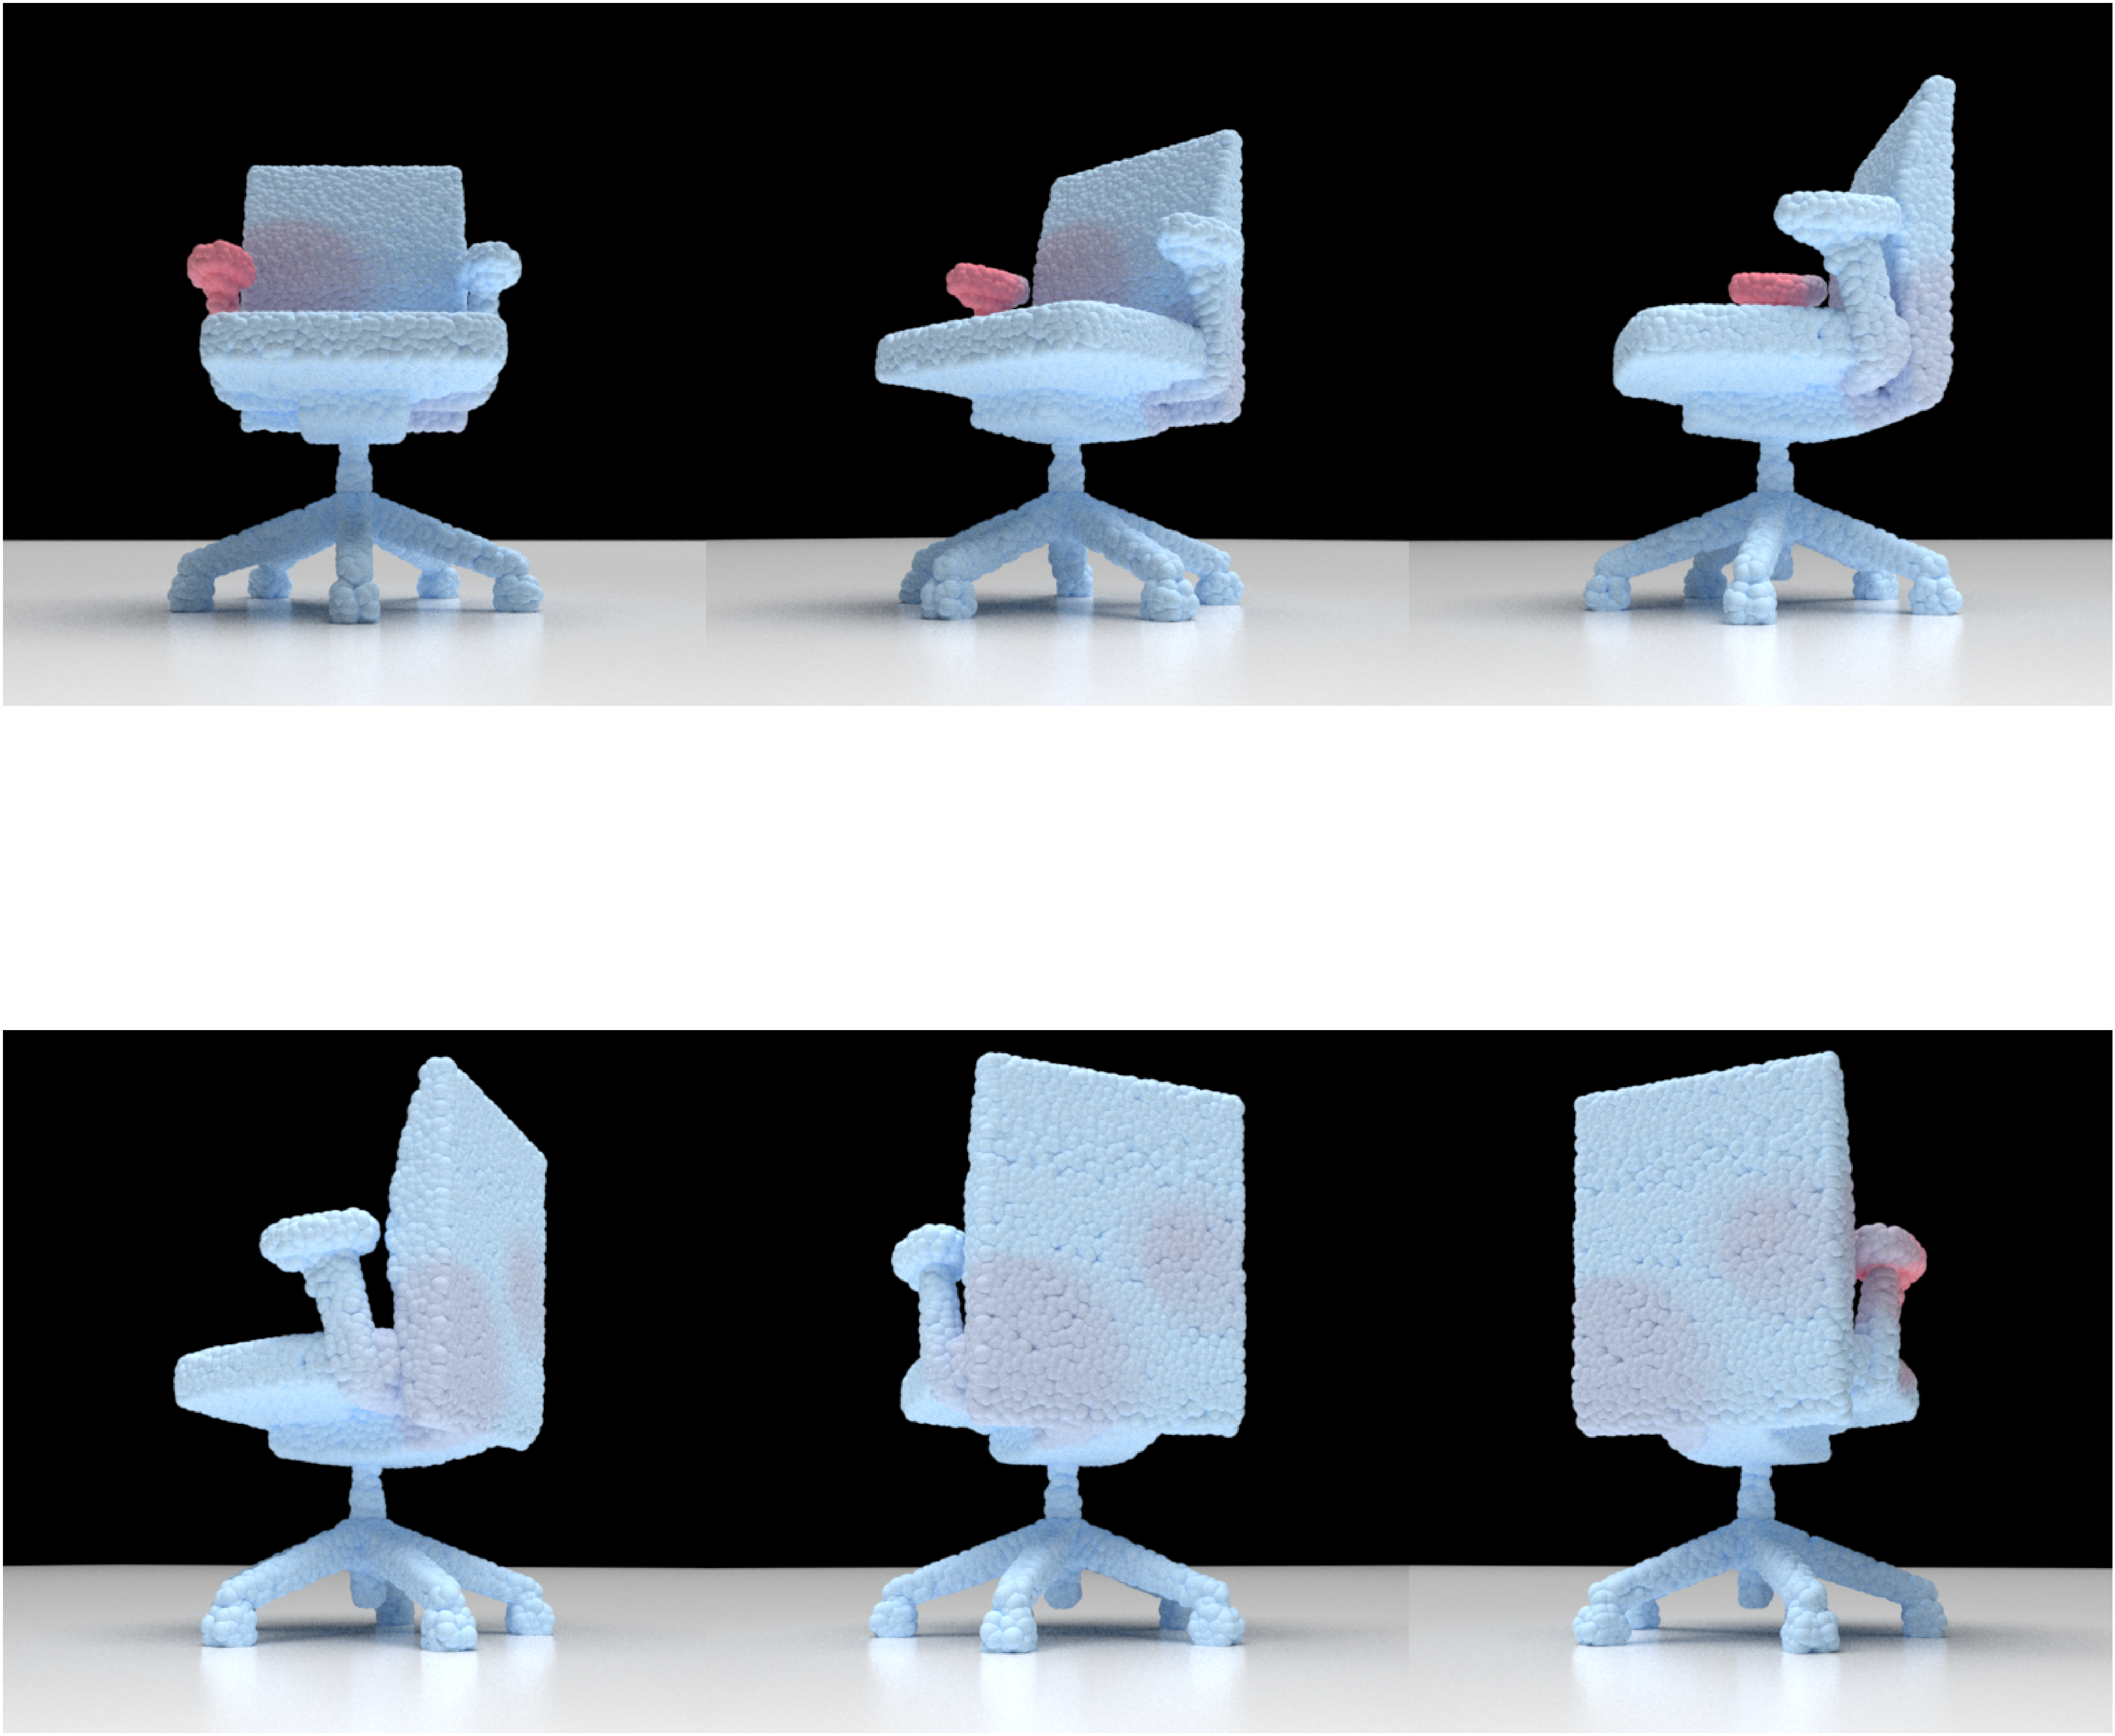

In [26]:
# Plot and save images

for i,image in enumerate(images):   # save images to disk
    path = os.path.join(output_path, "cabinet_{}".format(cabinet_id))
    if not os.path.exists(path) :
        os.makedirs(path)
    mi.util.write_bitmap(os.path.join(path, "view_{}.png").format(i), image)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(90, 90))
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(sensor_count):
    ax = fig.add_subplot(1+(sensor_count-1)//3, 3, i + 1).imshow(images[i] ** (1.0 / 2.2))
    plt.axis("off")